In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Express Deep Learning in Python

## How fast can you build a MLP?

In this tutorial we aim to give you some notions on how Deep Learning algorithms are implemented and the key points to use them and not get burned in the process. We will center on how to translate the theory of neural networks easily into efficient code with as little effort as possible. We won't teach you how to implement the complex algorithms involved, but rather how to ensemble the available parts to get the classification pipeline you want. You don't need to be an expert in machine learning or deep learning to understand this content, but some prior background is required. Also, we count on you knowing how to program in Python and how to use Jupyter Notebooks. 

In this first part we will see how to implement the basic components of a MultiLayer Perceptron (MLP) classifier, most commonly known as Neural Network. We will be working with the Keras: a very simple library for deep learning.

At this point, you may know how machine learning in general is applied and have some intuitions about how deep learning works, and more importantly, why it works. Now it's time to make some experiments, and for that you need to be as quick and flexible as possible. Keras is an idea tool for prototyping and doing your first approximations to a Machine Learning problem. On the one hand, Keras is integrated with two very powerfull backends that support GPU computations, Tensorflow and Theano. On the other hand, it has a level of abstraction high enough to be simple to understand and easy to use. For example, it uses a very similar interface to the sklearn library that you have seen before, with fit and predict methods.

Now let's get to work with an example:

### 1 - The libraries
Firts let's check we have installed everything we need for this tutorial:

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.datasets import mnist

Using Theano backend.


### 2 - The dataset

For this quick tutorial we will use the (very popular) [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This is a dataset of 70K images of handwritten digits. Our task is to recognize which digits is displayed in the image: a classification problem. You have seen in previous courses how to train and evaluate a classifier, so we wont talk in further details about supervised learning.

The input to the MLP classifier are going to be images of 28x28 pixels represented as matrixes. The output will be one of ten classes (0 to 9), representing the predicted number written in the image.

In [2]:
batch_size = 128
num_classes = 10
epochs = 10
TRAIN_EXAMPLES = 60000
TEST_EXAMPLES = 10000

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape the dataset to convert the examples from 2D matrixes to 1D arrays.
x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)

# to make quick runs, select a smaller set of images.
x_train = x_train[:TRAIN_EXAMPLES].astype('float32')
x_test = x_train[:TEST_EXAMPLES].astype('float32')

# normalize the input
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train[:TRAIN_EXAMPLES], num_classes)
y_test = keras.utils.to_categorical(y_test[:TEST_EXAMPLES], num_classes)

### 3 - The model

The concept of Deep Learning is very broad, but the core of it is the use of classifiers with multiple hidden layer of neurons, or smaller classifiers. We all know the classical image of the simplest possible possible deep model: a neural netowrk with a single hidden layer. 

![Neural Network](files/NeuralNetwork.png "Title")

credits http://www.extremetech.com/wp-content/uploads/2015/07/NeuralNetwork.png

In theory, this model can represent any function ***TODO*** add a citation here. We will see how to implement this network in Keras, and during the second part of this tutorial how to add more features to create a deep and powerful classifier.

First, Deep Learning models are concatenations of Layers. This is represented in Keras with the Sequential model. We create the Sequential instance as an "empty carcass" and then we fill it with different layers. 

The most basic type of Layer is the Dense layer, where each neuron in the input is connected to each neuron in the following layer, like we can see in the image above. Internally, a Dense layer has two variables: a matrix of weights and a vector of bias, but you beauty of Keras is that you don't need to worry about that. All the variables will be correctly created, initialized, trained and possibly regularized for you.

Each layer needs to know or be able to calculate al least three things:

* The size of the input: the number of neurons in the incoming layer. For the first layer this corresponds to the size of each example in our dataset. The next layers can calculate their input size using the output of the previous layer, so we generally don't need to tell them this.
* The type of activation: this is the function that is applied to the output of each neuron. Will talk in detail about this later.
* The size of the output: the number of neurons in the next layer.

In [3]:
model = Sequential()

# Input to hidden layer
model.add(Dense(512, activation='relu', input_shape=(784,)))
# Hidden to output layer
model.add(Dense(10, activation='softmax'))

We have successfully build a Neural Network! We can print a description of our architecture using the following command:

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


#### Compiling a model in Keras

A very appealing aspect of Deep Learning frameworks is that they solve the implementation of complex algorithms such as Backpropagation. For those with some numerical optimization notions, minimization algorithms often involve the calculation of first defivatives. Neural Networks are huge functions full of non-linearities, and differentiating them is a... nightmare. For this reason, models need to be "compiled". In this stage, the backend builds complex computational graphs, and we don't have to worry about derivatives or gradients.

In Keras, a model can be compiled with the method `.compile()`. The method takes two parameters: loss and optimizer. The **loss** is the function that calculates how much error we have in each prediction example, and there are a lot of implemented alternatives ready to use. We will talk more about this, for now we use the standard categorical crossentropy. As you can see, we can simply pass a string with the name of the function and Keras will find the implementation for us. We could, as well, pass a custom function as parameter.

The **optimizer** is the algorithm to minimize the value of the loss function. Again, Keras has many optimizers available. The basic one is the Stochastic Gradient Descent.

We pass a third argument to the `compile` method: the metric. **Metrics** are measures or statistics that allows us to keep track of the classifier's performance. It's similar to the loss, but the results of the metrics are not use by the optimization algorithm. Also, we can monitor how other performance metrics vary when the loss is optimized and detect anomalies. **TODO** metrics are calculated on the validation dataset?

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

[OPTIONAL] We can now visualize the architecture of our model using the `vis_util` tools. It's a very schematic view, but you can check it's not that different from the image we saw above (and that we intended to replicate).

If you can't execute this step don't worry, you can still finish the tutorial. This step requires graphviz and pydotplus libraries.

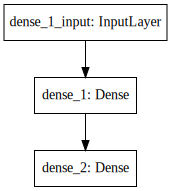

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Once the model is compiled, everything is ready to train the classifier. Keras' `Sequential` model has a similar interface as the sklearn library that you have seen before, with `fit` and `predict` methods. As usual, we need to pass our training examples and their corresponding labels. Other parameters needed to train a neural network is the size of the batch and the number of epochs. We have two ways of specifying a validation dataset: we can pass the tuple of values and labels directly with the `validation_data` parameter, or we can pass a proportion to the `validation_split` argument and Keras will split the training dataset for us.

In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s - loss: 0.1381 - acc: 0.9595 - val_loss: 9.5961 - val_acc: 0.1002
Epoch 2/10
60000/60000 [==============================] - 4s - loss: 0.0795 - acc: 0.9764 - val_loss: 10.6274 - val_acc: 0.0996
Epoch 3/10
60000/60000 [==============================] - 5s - loss: 0.0543 - acc: 0.9838 - val_loss: 11.1379 - val_acc: 0.0998
Epoch 4/10
60000/60000 [==============================] - 5s - loss: 0.0379 - acc: 0.9891 - val_loss: 11.8913 - val_acc: 0.1000
Epoch 5/10
18176/60000 [========>.....................] - ETA: 3s - loss: 0.0264 - acc: 0.9930

We have trained our model!

**TODO** add more about the metrics that we can see in the logs and why they are useful.

Keras gives us a very useful method to evaluate the current performance called `evaluate` (surprise!). Evaluate will return the value of the loss function and all the metrics that we pass to the model when calling compile.

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 10.378407814
Test accuracy: 0.095


As you can see, using only 10 training epochs we don't get a very surprising accuracy in the validation and test dataset. However, we get nearly perfect accuracy in the training dataset. In short, the model is overfitting. This may be happening because our model is trained with very few epochs, but most likely it happens because our model is too simple and can't generalize to unseen data.

In [8]:
prediction = model.predict_classes(x_test)

 7680/10000 [======================>.......] - ETA: 0s

In [20]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('colorblind')

In [ ]:
import numpy
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(numpy.argmax(x_test, 1), prediction)
colormap = plt.cm.cubehelix_r
figure = sns.heatmap(matrix, annot=True, fmt="d", linewidths=.5,
                     xticklabels=range(10), yticklabels=range(10),
                     cmap=sns.cubehelix_palette(8,  as_cmap=True))
# plt.show()

KeyboardInterrupt: 

In [ ]:
matrix.shape

## Practical task

Experiment modifying the above model by adding more dense layers, changing the number of neurons and examine how the validation and testing performance changes. Is it useful to add other metrics like the f1 score? What about printing the confusion matrixes?